# Redes Neurais Recorrentes com PyTorch

Este notebook explora a teoria e a implementação de Redes Neurais Recorrentes (RNNs) utilizando PyTorch. As RNNs são uma classe de redes neurais especializadas no processamento de dados sequenciais, como séries temporais ou texto.

## Conteúdos Abordados

1.  **Fundamentos Teóricos das RNNs**: O conceito de recorrência e o estado oculto.
2.  **Implementando uma RNN**: Construção de uma célula RNN.
3.  **O Módulo `torch.nn.RNN`**: Utilizando a implementação otimizada do PyTorch.
4.  **Exemplo 1: Predição de Séries Temporais**: Um modelo autorregressivo para prever o próximo valor de uma sequência numérica.
5.  **Exemplo 2: Predição do Próximo Caractere**: Um modelo de linguagem em nível de caractere.

## 1. Fundamentos Teóricos das RNNs

Diferentemente das redes neurais *feedforward*, as RNNs possuem um "laço" em sua arquitetura que permite que a informação persista. Essa característica é fundamental para o processamento de sequências, pois a rede pode manter um "estado" ou "memória" das informações vistas em passos de tempo anteriores.

A recorrência é matematicamente definida pela seguinte relação, onde em cada passo de tempo $t$, a saída do estado oculto $h_t$ é uma função do estado oculto anterior $h_{t-1}$ e da entrada atual $x_t$:

$$
h_t = f(W_{hh}h_{t-1} + W_{xh}x_t + b_h)
$$

A saída da rede em um determinado passo de tempo, $y_t$, é tipicamente uma função do estado oculto $h_t$:

$$
y_t = W_{hy}h_t + b_y
$$

Onde:
-   $x_t$: Vetor de entrada no tempo $t$.
-   $h_t$: Vetor do estado oculto (memória) no tempo $t$.
-   $y_t$: Vetor de saída no tempo $t$.
-   $W_{xh}, W_{hh}, W_{hy}$: Matrizes de pesos (entrada-oculto, oculto-oculto, oculto-saída).
-   $b_h, b_y$: Vetores de viés (bias).
-   $f$: Função de ativação não linear, comumente `tanh` ou `ReLU`.

Essa estrutura permite que a RNN compartilhe os mesmos parâmetros ($W, b$) ao longo de toda a sequência, tornando-a eficiente.

## 2. Implementando uma RNN

Para solidificar o entendimento, podemos implementar uma célula RNN simples usando apenas as operações fundamentais do PyTorch. Uma célula RNN processa um único passo de tempo da sequência.

In [5]:
import torch
from torch import nn

class SimpleRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Camada para entrada -> hidden
        self.input2hidden = nn.Linear(input_size, hidden_size)

        # Camada para hidden -> hidden (recorrência)
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size, bias=False)

        # Função de ativação
        self.activation = nn.Tanh()

    def forward(self, x_t, h_prev):
        # h_t = tanh(W_xh * x_t + W_hh * h_prev + b)
        h_t = self.activation(
            self.input2hidden(x_t) + self.hidden2hidden(h_prev)
        )
        return h_t

# Exemplo de uso
batch_size = 5
input_size = 10
hidden_size = 20

cell = SimpleRNNCell(input_size, hidden_size)
x_t = torch.randn(batch_size, input_size)
h_prev = torch.randn(batch_size, hidden_size)

h_next = cell(x_t, h_prev)
print(f"Formato da entrada (x_t): {x_t.shape}")
print(f"Formato do estado oculto anterior (h_prev): {h_prev.shape}")
print(f"Formato do estado oculto de saída (h_next): {h_next.shape}")

Formato da entrada (x_t): torch.Size([5, 10])
Formato do estado oculto anterior (h_prev): torch.Size([5, 20])
Formato do estado oculto de saída (h_next): torch.Size([5, 20])


In [6]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.cell = SimpleRNNCell(input_size, hidden_size)

    def forward(self, x_sequence):
        # x_sequence: [batch_size, sequence_length, input_size]
        batch_size = x_sequence.size(0)

        # Inicializa o estado oculto com zeros
        h_t = torch.zeros(batch_size, self.hidden_size)

        # Lista para armazenar as saídas de cada passo de tempo
        outputs = []

        # Itera sobre cada passo de tempo na sequência
        for t in range(x_sequence.size(1)):
            x_t = x_sequence[:, t, :] # Pega a entrada no tempo t
            h_t = self.cell(x_t, h_t)
            outputs.append(h_t)

        # Empilha as saídas
        # A saída final terá formato [batch_size, sequence_length, hidden_size]
        return torch.stack(outputs, dim=1)

# Exemplo de uso com uma sequência
seq_length = 7
rnn_from_scratch = SimpleRNN(input_size, hidden_size)
x_sequence = torch.randn(batch_size, seq_length, input_size)

output_sequence = rnn_from_scratch(x_sequence)
print(f"Formato da sequência de entrada: {x_sequence.shape}")
print(f"Formato da sequência de saída: {output_sequence.shape}")

Formato da sequência de entrada: torch.Size([5, 7, 10])
Formato da sequência de saída: torch.Size([5, 7, 20])


## 3. O Módulo `torch.nn.RNN`

Na prática utilizamos o módulo `torch.nn.RNN`, que é altamente otimizado e mais robusto.

Seus parâmetros principais são:
-   `input_size`: A dimensionalidade da entrada $x_t$.
-   `hidden_size`: A dimensionalidade do estado oculto $h_t$.
-   `num_layers`: Número de camadas recorrentes empilhadas.
-   `batch_first`: Se `True`, o tensor de entrada e saída tem o formato `(batch, seq, feature)`. Caso contrário, `(seq, batch, feature)`. É altamente recomendado usar `True`.

Ele retorna dois tensores:
1.  `output`: Contém o estado oculto de saída para **cada** passo de tempo da sequência.
2.  `h_n`: Contém o estado oculto **final** do último passo de tempo.

In [7]:
# Usando o módulo nativo do PyTorch
# É importante usar batch_first=True para consistência
rnn_pytorch = nn.RNN(input_size, hidden_size, num_layers=2, batch_first=True)

# A entrada é a mesma sequência de antes
output_pytorch, h_n_pytorch = rnn_pytorch(x_sequence)

print(f"Formato da sequência de entrada: {x_sequence.shape}")
print(f"Formato da sequência de saída (output): {output_pytorch.shape}")
print(f"Formato do estado oculto final (h_n): {h_n_pytorch.shape}")

Formato da sequência de entrada: torch.Size([5, 7, 10])
Formato da sequência de saída (output): torch.Size([5, 7, 20])
Formato do estado oculto final (h_n): torch.Size([2, 5, 20])


## 4. Exemplo 1: Predição de Séries Temporais

Neste exemplo, treinaremos uma RNN para prever o próximo valor de uma onda senoidal, baseando-se nos valores anteriores. Esta é uma tarefa de regressão autorregressiva.

Primeiro, geramos os dados e os estruturamos em sequências de entrada e seus respectivos alvos. Se a nossa sequência de entrada tem tamanho `L`, o modelo usará `data[0:L]` para prever `data[L]`.

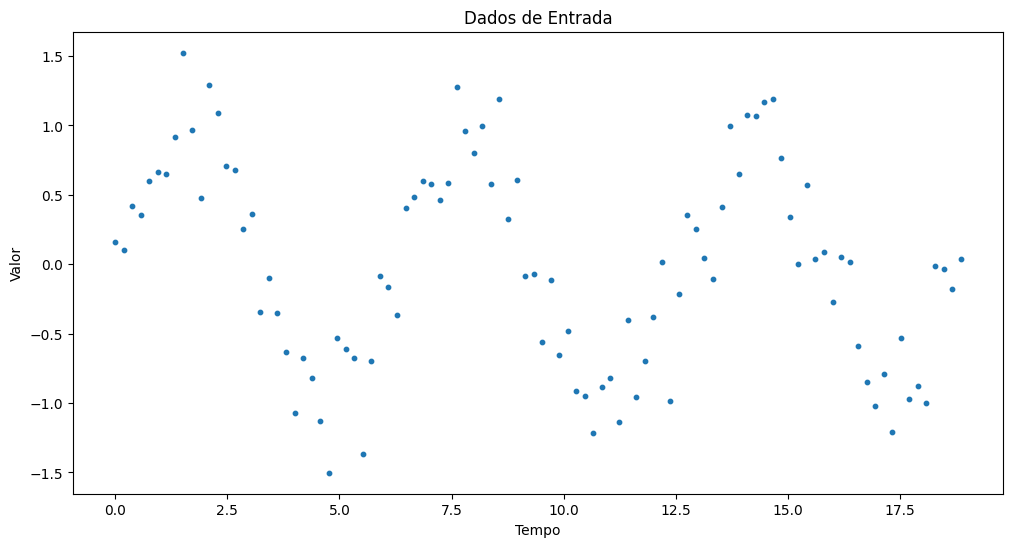

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Parâmetros
sequence_length = 20
noise_factor = 0.3 # Fator de ruído para simular medições

# Gera os dados: uma onda senoidal já está em uma boa escala (~[-1, 1])
time_steps = np.linspace(0, 6*np.pi, 100)
data = np.sin(time_steps) + np.random.randn(len(time_steps)) * noise_factor

# Converte para tensor do PyTorch
data_tensor = torch.FloatTensor(data).view(-1, 1)

# Plota os dados de entrada
plt.figure(figsize=(12, 6))
plt.scatter(time_steps, data, s=10)
plt.title("Dados de Entrada")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

In [9]:
# Função para criar as sequências de entrada e os rótulos
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

# Cria as sequências e divide em treino/teste
X, y = create_sequences(data_tensor, sequence_length)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o DataLoader para o treinamento
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesPredictor, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, seq_length, input_size]
        # Pegamos a saída do último passo de tempo da RNN
        # rnn_out: [batch_size, seq_length, hidden_size]
        rnn_out, _ = self.rnn(x)
        last_time_step_out = rnn_out[:, -1, :]

        # Passamos pela camada linear
        # out: [batch_size, output_size]
        out = self.fc(last_time_step_out)
        return out

In [11]:
# Instanciando o modelo
model = TimeSeriesPredictor(input_size=1, hidden_size=20, output_size=1)
criterion = nn.MSELoss() # Mean Squared Error para regressão
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  0%|          | 0/500 [00:00<?, ?it/s]

Treinamento concluído!


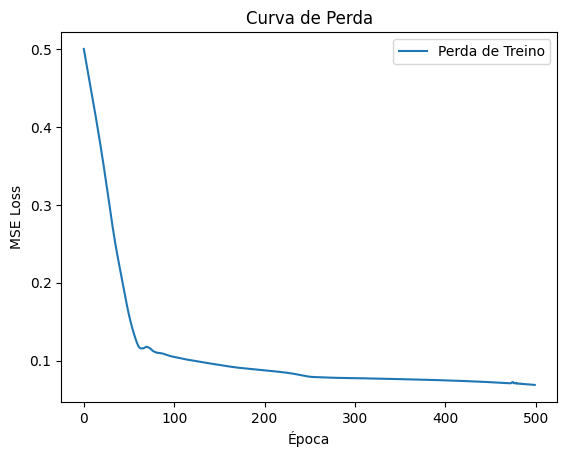

In [12]:
from tqdm.notebook import tqdm

# Loop de Treinamento
num_epochs = 500
train_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0

    for sequences, labels in train_loader:
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

print("Treinamento concluído!")
plt.plot(train_losses, label='Perda de Treino')
plt.title("Curva de Perda")
plt.xlabel("Época")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

### Inferência com Geração Autoregressiva

Até agora, avaliamos o modelo fazendo previsões de um passo à frente (*one-step-ahead*), ou seja, usando sempre dados reais como entrada. Uma forma mais robusta de avaliar um modelo de série temporal é através da **geração autorregressiva**.

Neste processo, utilizamos a saída do próprio modelo como entrada para a próxima predição. Começamos com uma sequência inicial de dados reais (a "semente" ou *seed*) e, a partir dela, geramos o restante da série.

Matematicamente, se o modelo é uma função $f$ e $L$ é o tamanho da sequência de entrada:
1.  A primeira predição $\hat{y}_{t}$ é baseada em dados reais:
    $$ \hat{y}_{t} = f(x_{t-L}, \ldots, x_{t-1}) $$
2.  A segunda predição $\hat{y}_{t+1}$ usa a primeira predição $\hat{y}_{t}$ como parte da nova sequência de entrada:
    $$ \hat{y}_{t+1} = f(x_{t-L+1}, \ldots, x_{t-1}, \hat{y}_{t}) $$
3.  O processo continua, com cada nova predição sendo adicionada à janela de entrada para a predição subsequente:
    $$ \hat{y}_{t+k} = f(\ldots, \hat{y}_{t+k-2}, \hat{y}_{t+k-1}) $$

Este método é um teste mais rigoroso, pois os erros do modelo podem se acumular ao longo do tempo. Uma boa previsão autorregressiva indica que o modelo aprendeu bem a dinâmica subjacente da série.

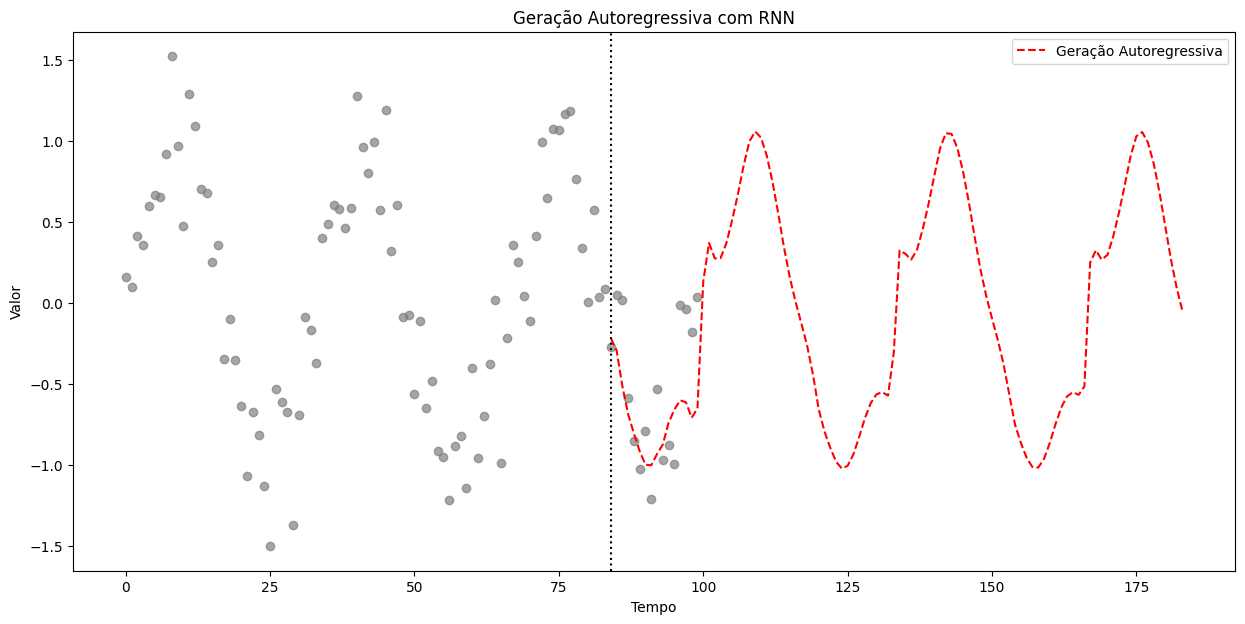

In [13]:
# Geração autorregressiva
model.eval()

# Pega a primeira sequência do conjunto de teste como semente inicial
current_seq = X_test[0]
# Número de pontos a serem gerados
generation_steps = 100
# Lista para armazenar as previsões
generated_predictions = []

with torch.no_grad():
    for _ in range(generation_steps):
        # Adiciona a dimensão do batch (1, seq_len, input_size)
        input_tensor = current_seq.unsqueeze(0)

        # Faz a predição
        prediction = model(input_tensor)

        # Armazena a predição
        generated_predictions.append(prediction.item())

        # Atualiza a sequência de entrada para a próxima iteração
        current_seq = torch.cat((current_seq[1:], prediction), dim=0)

# Converte listas e tensores para numpy para plotagem
generated_predictions = np.array(generated_predictions)
original_data = data_tensor.numpy().flatten()
seed_data = X_test[0].numpy().flatten()

seed_start_index = train_size
seed_end_index = train_size + sequence_length

# Plot
plt.figure(figsize=(15, 7))

# Plot dos dados originais
plt.scatter(range(original_data.shape[0]), original_data, color='gray', alpha=0.7)

# Plot da geração autorregressiva
generated_indices = range(seed_end_index, seed_end_index + generation_steps)
plt.plot(generated_indices, generated_predictions, label='Geração Autoregressiva', color='red', linestyle='--')

plt.title("Geração Autoregressiva com RNN")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.axvline(x=seed_end_index, color='black', linestyle=':', label='Início da Geração')
plt.show()

## 5. Exemplo 2: Predição do Próximo Caractere

Neste exemplo, treinaremos uma RNN para prever o próximo caractere em uma sequência de texto. Esta é uma tarefa de classificação, onde as "classes" são todos os caracteres possíveis no nosso vocabulário.

O processo envolve:
1.  Criar um vocabulário de caracteres únicos.
2.  Mapear cada caractere para um número inteiro.
3.  Representar a entrada como `one-hot vectors`, que é uma forma de representar dados categóricos.
4.  Treinar a rede para, dada uma sequência de caracteres, prever o próximo.

In [14]:
# 1. Preparar os dados
text = "o rato roeu a roupa do rei de roma"
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

print(f"Tamanho do vocabulário: {vocab_size}")
print(f"Vocabulário: {''.join(chars)}")

Tamanho do vocabulário: 11
Vocabulário:  adeimoprtu


In [15]:
# 2. Criar sequências e alvos como listas de inteiros
seq_len = 5
input_seqs_list = []
target_seqs_list = []
for i in range(len(text) - seq_len):
    in_seq = text[i:i+seq_len]
    target = text[i+seq_len]
    input_seqs_list.append([char_to_int[ch] for ch in in_seq])
    target_seqs_list.append(char_to_int[target])

input_seqs_list[0], target_seqs_list[0]

([6, 0, 8, 1, 9], 6)

In [16]:
# 3. Converter as listas em tensores de índices (não mais one-hot)
# A entrada da camada Embedding deve ser do tipo LongTensor
X_char_indices = torch.LongTensor(input_seqs_list)
y_char_labels = torch.LongTensor(target_seqs_list)

print(f"Formato de X_char_indices (Entrada): {X_char_indices.shape}")
print(f"Formato de y_char_labels (Alvo): {y_char_labels.shape}")

Formato de X_char_indices (Entrada): torch.Size([29, 5])
Formato de y_char_labels (Alvo): torch.Size([29])


In [17]:
class CharPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(CharPredictor, self).__init__()
        # Camada de Embedding: Mapeia cada índice de caractere para um vetor denso
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # A entrada da RNN agora é a dimensão do embedding
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)

        # Camada de saída mapeia do espaço oculto para o vocabulário
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # x: [batch_size, seq_len] (tensores de índices)
        x = self.embedding(x)
        # após embedding, x: [batch_size, seq_len, embedding_dim]

        rnn_out, _ = self.rnn(x)
        # rnn_out: [batch_size, seq_len, hidden_size]

        # Usamos a saída do último passo de tempo para a previsão
        out = self.fc(rnn_out[:, -1, :])
        # out: [batch_size, vocab_size]
        return out

In [18]:
# Parâmetros
embedding_dim = 4
hidden_size = 8

# Instanciando o modelo
model_char = CharPredictor(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_size=hidden_size)
criterion_char = nn.CrossEntropyLoss()
optimizer_char = torch.optim.Adam(model_char.parameters(), lr=0.01)

In [19]:
# Loop de Treinamento
num_epochs_char = 2000
for epoch in range(num_epochs_char):
    model_char.train()
    # Passa o tensor de índices diretamente para o modelo
    outputs = model_char(X_char_indices)
    loss = criterion_char(outputs, y_char_labels)

    optimizer_char.zero_grad()
    loss.backward()
    optimizer_char.step()

    if (epoch+1) % 100 == 0:
        print(f'Época [{epoch+1}/{num_epochs_char}], Perda: {loss.item():.4f}')

Época [100/2000], Perda: 0.2337
Época [200/2000], Perda: 0.0416
Época [300/2000], Perda: 0.0204
Época [400/2000], Perda: 0.0114
Época [500/2000], Perda: 0.0079
Época [600/2000], Perda: 0.0060
Época [700/2000], Perda: 0.0047
Época [800/2000], Perda: 0.0038
Época [900/2000], Perda: 0.0032
Época [1000/2000], Perda: 0.0027
Época [1100/2000], Perda: 0.0023
Época [1200/2000], Perda: 0.0020
Época [1300/2000], Perda: 0.0018
Época [1400/2000], Perda: 0.0016
Época [1500/2000], Perda: 0.0014
Época [1600/2000], Perda: 0.0012
Época [1700/2000], Perda: 0.0011
Época [1800/2000], Perda: 0.0010
Época [1900/2000], Perda: 0.0009
Época [2000/2000], Perda: 0.0008


In [20]:
# Gerando texto com o modelo treinado
model_char.eval()

# Começa com uma sequência aleatória do nosso dataset
start_idx = np.random.randint(0, len(input_seqs_list) - 1)
seed_seq_int = input_seqs_list[start_idx] # Usa a lista de inteiros
seed_seq_text = ''.join([int_to_char[i] for i in seed_seq_int])
generated_text = seed_seq_text
original_text = generated_text # Removed .copy()
original_seed_seq_int = seed_seq_int.copy()
print(f"Semente inicial: '{seed_seq_text}'")
temperatures = [1.5, 1, -1.5]


for temperature in temperatures:
  seed_seq_int = original_seed_seq_int.copy()
  generated_text = original_text # Removed .copy()
  with torch.no_grad():
      for _ in range(100): # Gerar 50 novos caracteres
          # Prepara a sequência de entrada como um LongTensor
          input_tensor = torch.LongTensor([seed_seq_int]) # Batch size de 1

          # Obtém a previsão do modelo (logits)
          output_logits = model_char(input_tensor)/temperature

          # Amostragem para obter o próximo caractere
          probabilities = nn.functional.softmax(output_logits, dim=1)
          predicted_idx = torch.multinomial(probabilities, 1).item()

          # Adiciona o caractere previsto ao texto gerado
          generated_text += int_to_char[predicted_idx]

          # Atualiza a sequência de entrada para a próxima iteração
          seed_seq_int = seed_seq_int[1:] + [predicted_idx]
  print(f"\nTemperatura: {temperature}")
  print(f"Texto gerado: '{generated_text}'")

Semente inicial: 'a do '

Temperatura: 1.5
Texto gerado: 'a do rei de roma roma domromaeu a roupa do rei de roma romroma romr  roupa do rei de roma romromroma romr'

Temperatura: 1
Texto gerado: 'a do rei de roma roma roma roma roma roma romau rei de roma roma roma roma roma romroma roma roma roma ro'

Temperatura: -1.5
Texto gerado: 'a do eretmrmeddrmeererepetmrdpdpdmpemmrdutmddureoaeretmrmedarmuaedmrdapdmdppeperepepemeredmididmmeedmremm'


### Análise da Inferência: Visualizando as Probabilidades

Para entender o que o modelo "pensa" em um determinado passo, podemos realizar uma única inferência e visualizar a distribuição de probabilidade que ele atribui a cada caractere do vocabulário para ser o próximo. Isso é feito aplicando a função `softmax` aos *logits* de saída do modelo. O gráfico resultante nos mostrará quais caracteres o modelo considera mais prováveis.

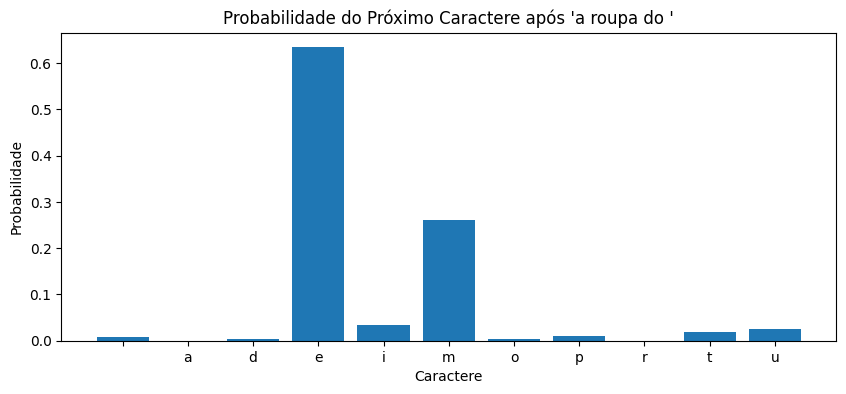

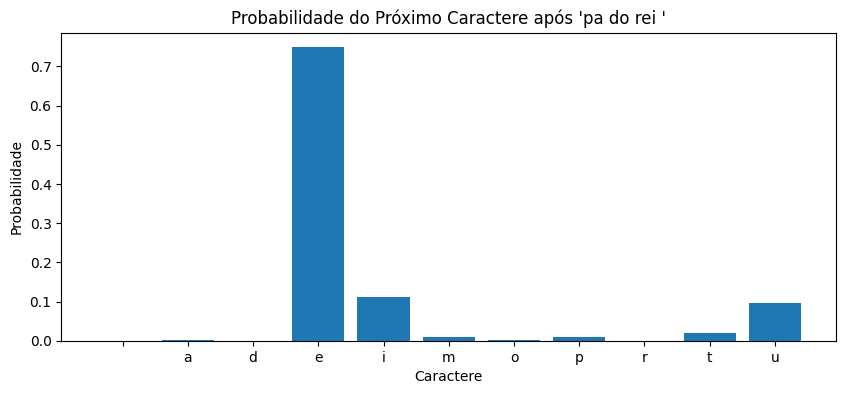

In [21]:
temperature = -2
# Função para plotar a distribuição de probabilidades
def plot_next_char_probabilities(model, seed_text):
    model.eval()

    # Prepara a sequência de entrada como um LongTensor
    seed_seq_int = [char_to_int[c] for c in seed_text]
    input_tensor = torch.LongTensor([seed_seq_int])

    # Inferência
    with torch.no_grad():
        output_logits = model(input_tensor)/temperature
        probabilities = nn.functional.softmax(output_logits, dim=1).squeeze()

    # Plot
    plt.figure(figsize=(10, 4))
    plt.bar(chars, probabilities.numpy())
    plt.title(f"Probabilidade do Próximo Caractere após '{seed_text}'")
    plt.ylabel("Probabilidade")
    plt.xlabel("Caractere")
    plt.show()

# Testando com uma sequência do texto
seed = "a roupa do "
plot_next_char_probabilities(model_char, seed)

# Outro teste
seed = "pa do rei "
plot_next_char_probabilities(model_char, seed)

### Exercícios

#### Exercício 1: Alterando a Função de Ativação

Modifique a classe `SimpleRNNCell` (a nossa implementação "do zero") para utilizar a função de ativação `nn.ReLU` em vez de `nn.Tanh`.

-   Depois da modificação, execute a célula novamente.
-   **Pergunta:** Qual a principal diferença no intervalo de valores que o estado oculto (`h_t`) pode assumir ao usar ReLU em comparação com Tanh? Como você acha que isso poderia impactar o treinamento de uma rede mais profunda?

In [22]:
import torch
from torch import nn

class SimpleRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Camada para entrada -> hidden
        self.input2hidden = nn.Linear(input_size, hidden_size)

        # Camada para hidden -> hidden (recorrência)
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size, bias=False)

        # Função de ativação
        self.activation = nn.ReLU()

    def forward(self, x_t, h_prev):
        # h_t = tanh(W_xh * x_t + W_hh * h_prev + b)
        h_t = self.activation(
            self.input2hidden(x_t) + self.hidden2hidden(h_prev)
        )
        return h_t

# Exemplo de uso
batch_size = 5
input_size = 10
hidden_size = 20

cell = SimpleRNNCell(input_size, hidden_size)
x_t = torch.randn(batch_size, input_size)
h_prev = torch.randn(batch_size, hidden_size)

h_next = cell(x_t, h_prev)
print(f"Formato da entrada (x_t): {x_t.shape}")
print(f"Formato do estado oculto anterior (h_prev): {h_prev.shape}")
print(f"Formato do estado oculto de saída (h_next): {h_next.shape}")

Formato da entrada (x_t): torch.Size([5, 10])
Formato do estado oculto anterior (h_prev): torch.Size([5, 20])
Formato do estado oculto de saída (h_next): torch.Size([5, 20])


In [23]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.cell = SimpleRNNCell(input_size, hidden_size)

    def forward(self, x_sequence):
        # x_sequence: [batch_size, sequence_length, input_size]
        batch_size = x_sequence.size(0)

        # Inicializa o estado oculto com zeros
        h_t = torch.zeros(batch_size, self.hidden_size)

        # Lista para armazenar as saídas de cada passo de tempo
        outputs = []

        # Itera sobre cada passo de tempo na sequência
        for t in range(x_sequence.size(1)):
            x_t = x_sequence[:, t, :] # Pega a entrada no tempo t
            h_t = self.cell(x_t, h_t)
            outputs.append(h_t)

        # Empilha as saídas
        # A saída final terá formato [batch_size, sequence_length, hidden_size]
        return torch.stack(outputs, dim=1)

# Exemplo de uso com uma sequência
seq_length = 7
rnn_from_scratch = SimpleRNN(input_size, hidden_size)
x_sequence = torch.randn(batch_size, seq_length, input_size)

output_sequence = rnn_from_scratch(x_sequence)
print(f"Formato da sequência de entrada: {x_sequence.shape}")
print(f"Formato da sequência de saída: {output_sequence.shape}")

Formato da sequência de entrada: torch.Size([5, 7, 10])
Formato da sequência de saída: torch.Size([5, 7, 20])


Tanh é mais seguro contra explosões, mas faz a rede ter amnésia em longo prazo. ReLU é mais agressivo, tem uma memória melhor, mas é propenso a erros catastróficos se não for controlado. A diferença no intervalo impacta a estabilidade do treino. Com Tanh, a memória limitada causa o Gradiente Desvanecente, impedindo as camadas profundas de aprender o passado distante. Com ReLU, a memória ilimitada pode levar ao Gradiente Explodindo, quebrando o treinamento, a não ser que se usem corte de gradiente.

#### Exercício 2: Otimizando o Previsor de Série Temporal

Experimente com os hiperparâmetros do modelo `TimeSeriesPredictor` para tentar obter uma geração autorregressiva mais precisa. Altere um de cada vez e analise o resultado:

1.  **Tamanho da Camada Oculta (`hidden_size`):** Teste um valor menor e um valor maior.
2.  **Tamanho da Sequência (`sequence_length`):** Altere o tamanho da janela de entrada para um valor menor e um maior. Você precisará recriar os dados para isso.
3.  **Taxa de Aprendizado (`learning_rate`):** Teste um valor uma ordem de magnitude menor (ex: 0.001).

-   **Análise:** Para cada mudança, observe a curva de perda e o gráfico de geração. Um modelo maior é sempre melhor? Qual o impacto de ver mais (ou menos) do passado da série?

#### Exercício 3: Aprofundando o Modelo

Modifique a arquitetura do `TimeSeriesPredictor` para usar duas camadas de RNN empilhadas.

-   **Dica:** A classe `nn.RNN` possui um parâmetro `num_layers`. Basta ajustá-lo.
-   **Pergunta:** O modelo com duas camadas converge mais rápido? A qualidade da geração autorregressiva melhora, piora ou permanece a mesma?


--- TESTE 2.1: HIDDEN SIZE (H=10, MAIOR) ---

--- Treinando Modelo (p=20, h=10, lr=0.01, layers=1) ---
Treinamento concluído! Perda Final (MSE): 0.0596


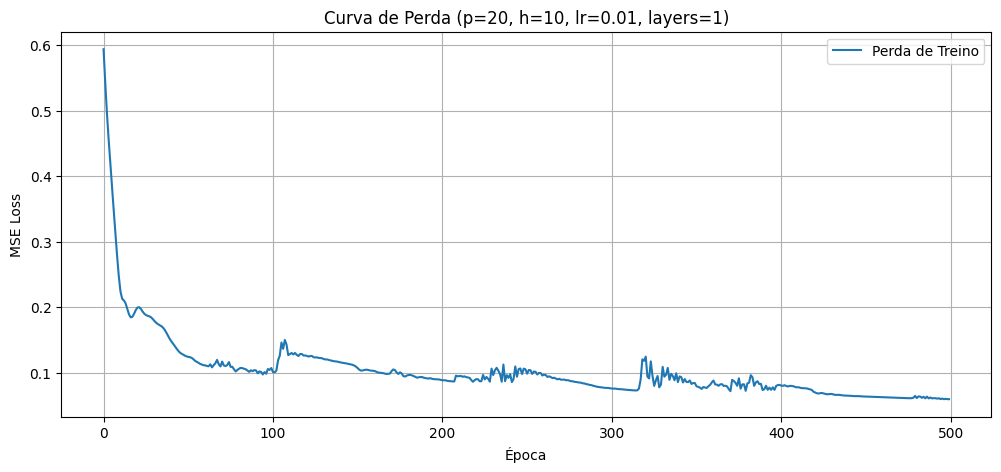

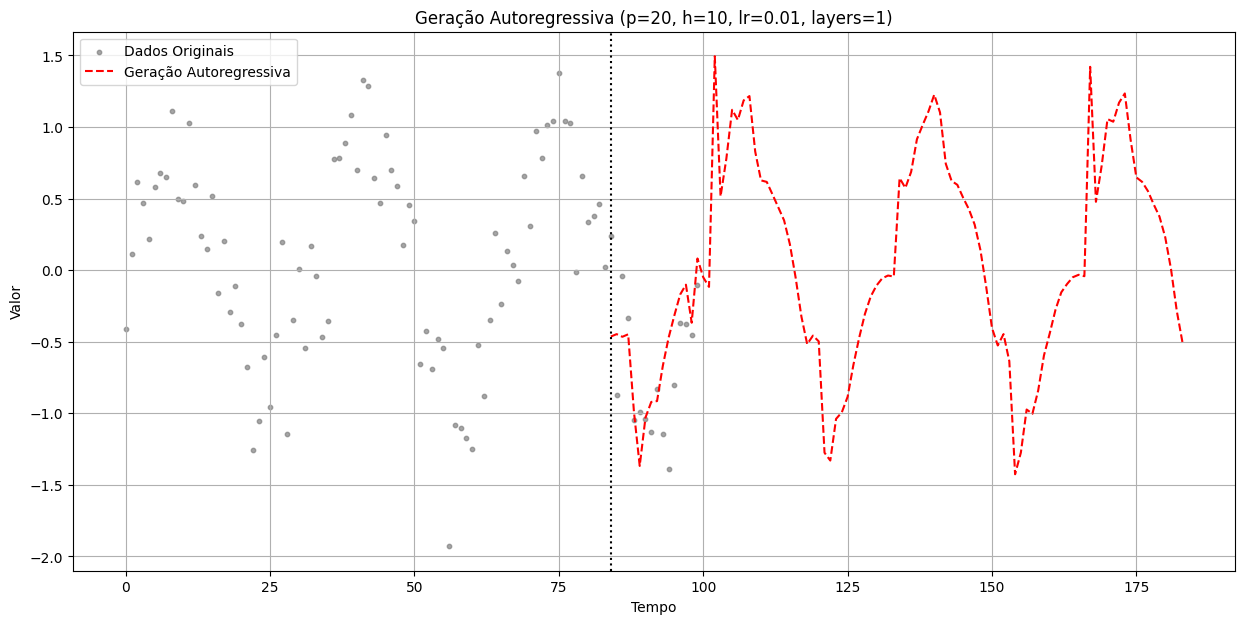


--- TESTE 2.1: HIDDEN SIZE (H=2, MENOR) ---

--- Treinando Modelo (p=20, h=2, lr=0.01, layers=1) ---
Treinamento concluído! Perda Final (MSE): 0.1440


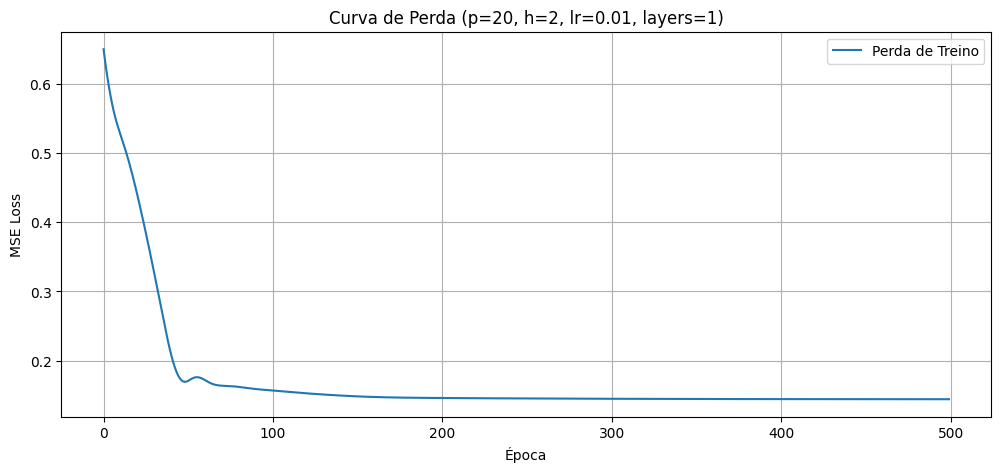

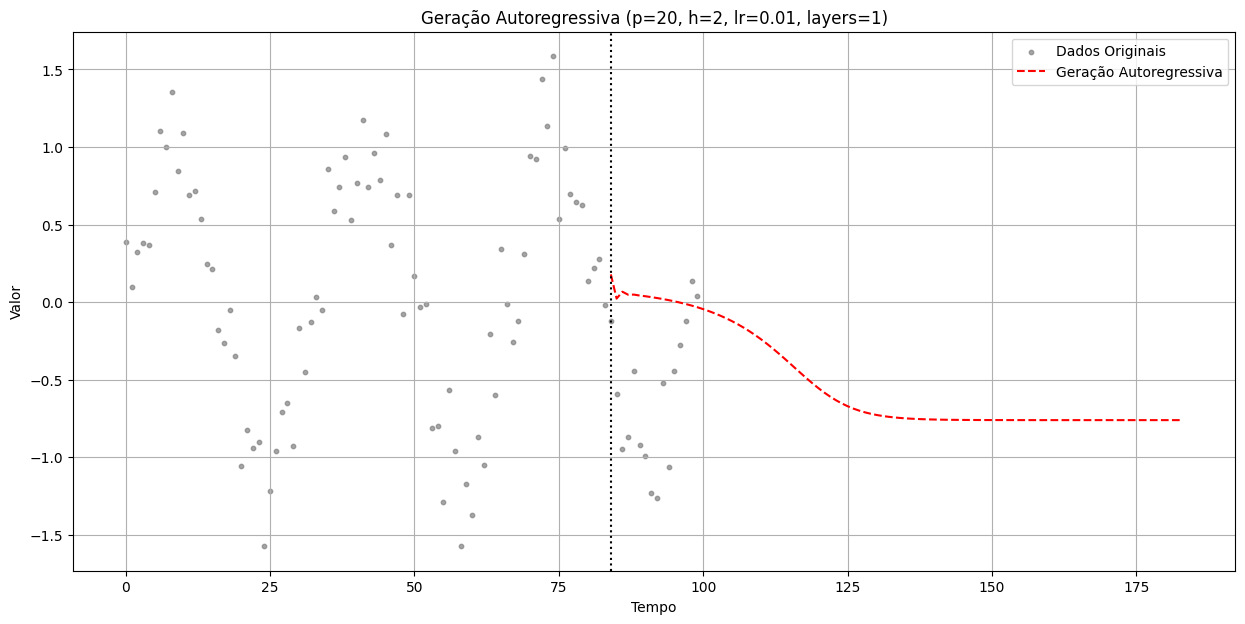


--- TESTE 2.2: SEQUENCE LENGTH (P=5, MENOR) ---

--- Treinando Modelo (p=5, h=4, lr=0.01, layers=1) ---
Treinamento concluído! Perda Final (MSE): 0.1405


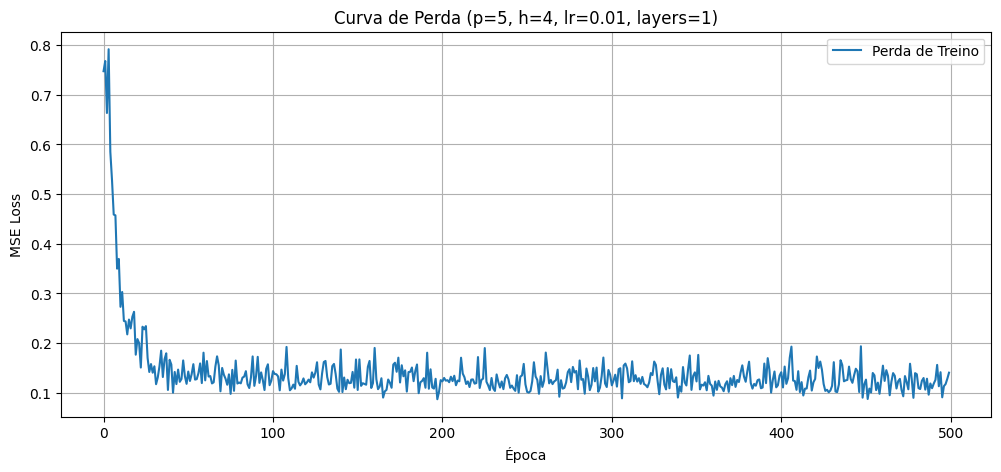

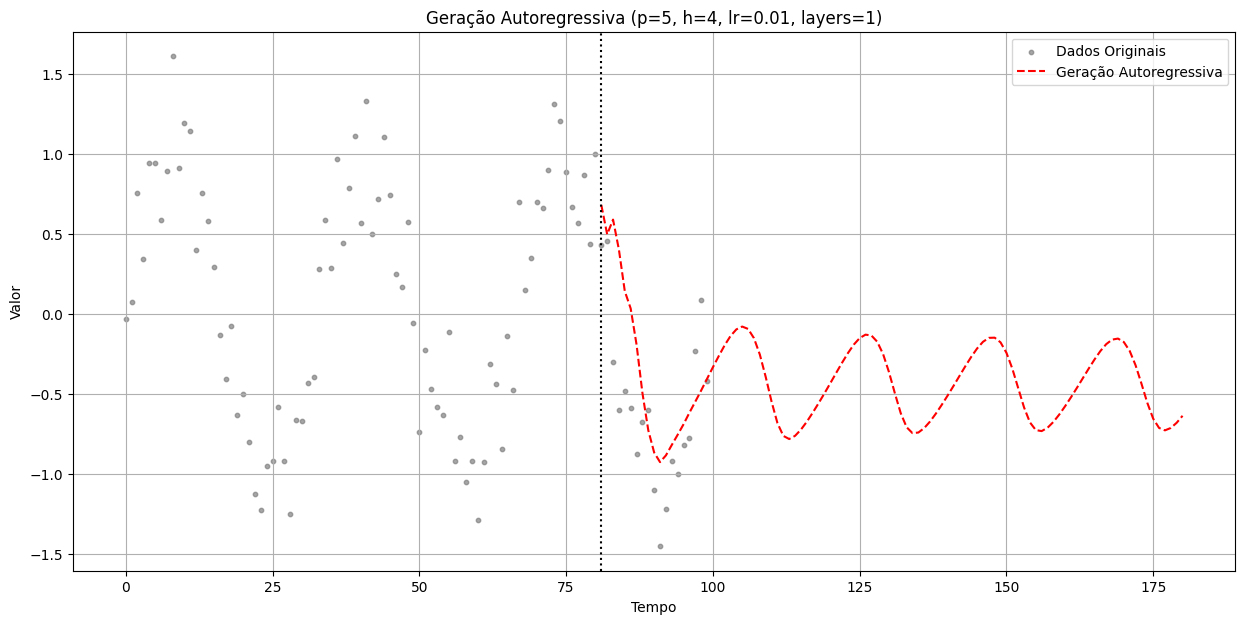


--- TESTE 2.2: SEQUENCE LENGTH (P=50, MAIOR) ---

--- Treinando Modelo (p=50, h=4, lr=0.01, layers=1) ---
Treinamento concluído! Perda Final (MSE): 0.0648


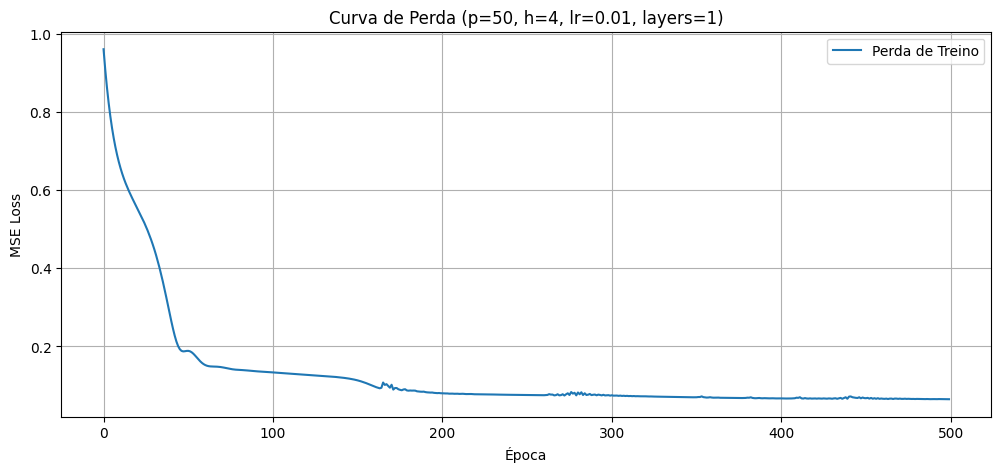

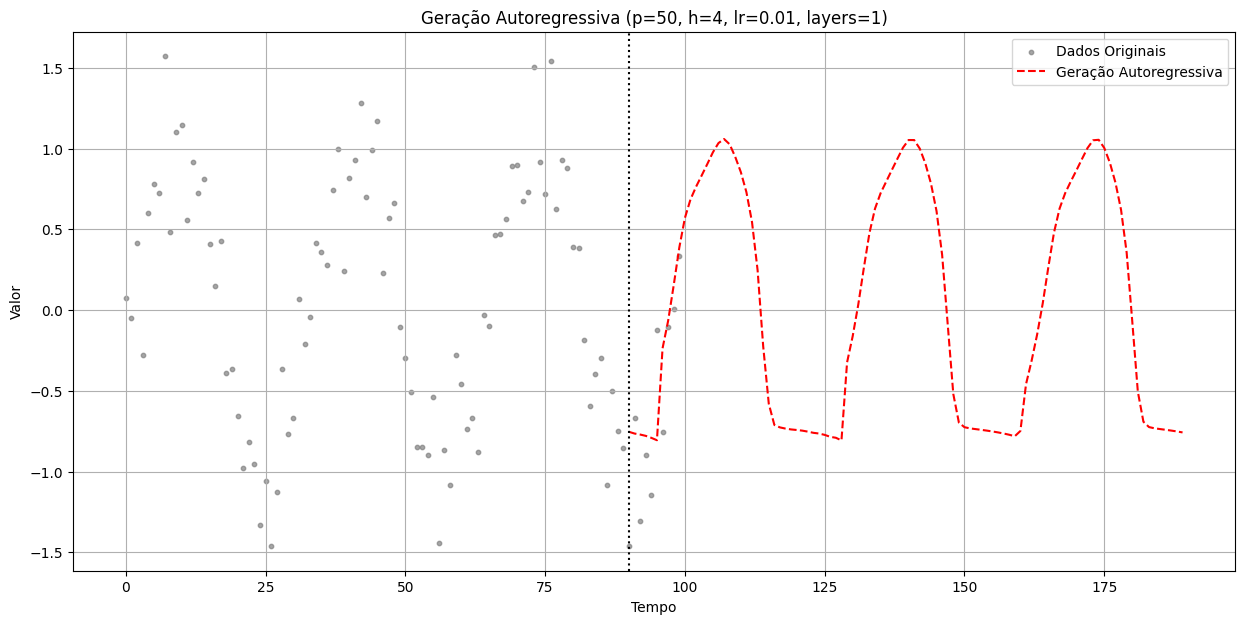


--- TESTE 2.3: LEARNING RATE (LR=0.001, MENOR) ---

--- Treinando Modelo (p=20, h=4, lr=0.001, layers=1) ---
Treinamento concluído! Perda Final (MSE): 0.1669


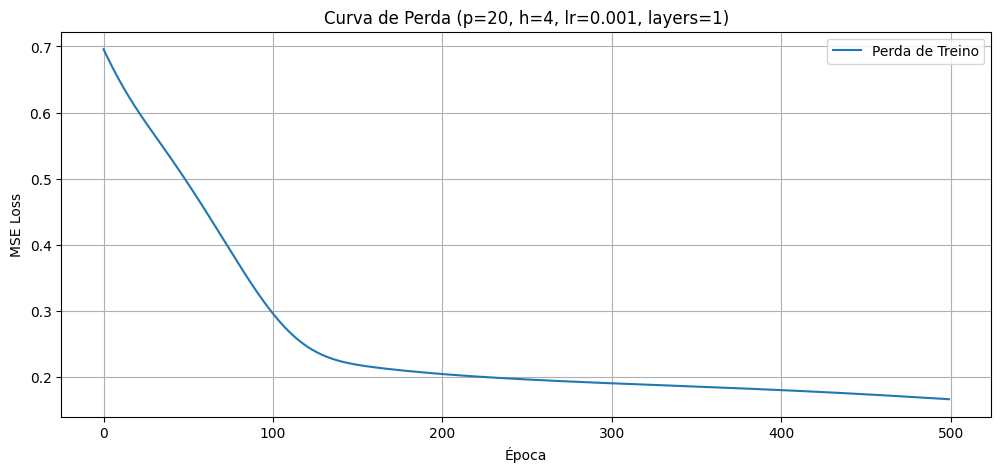

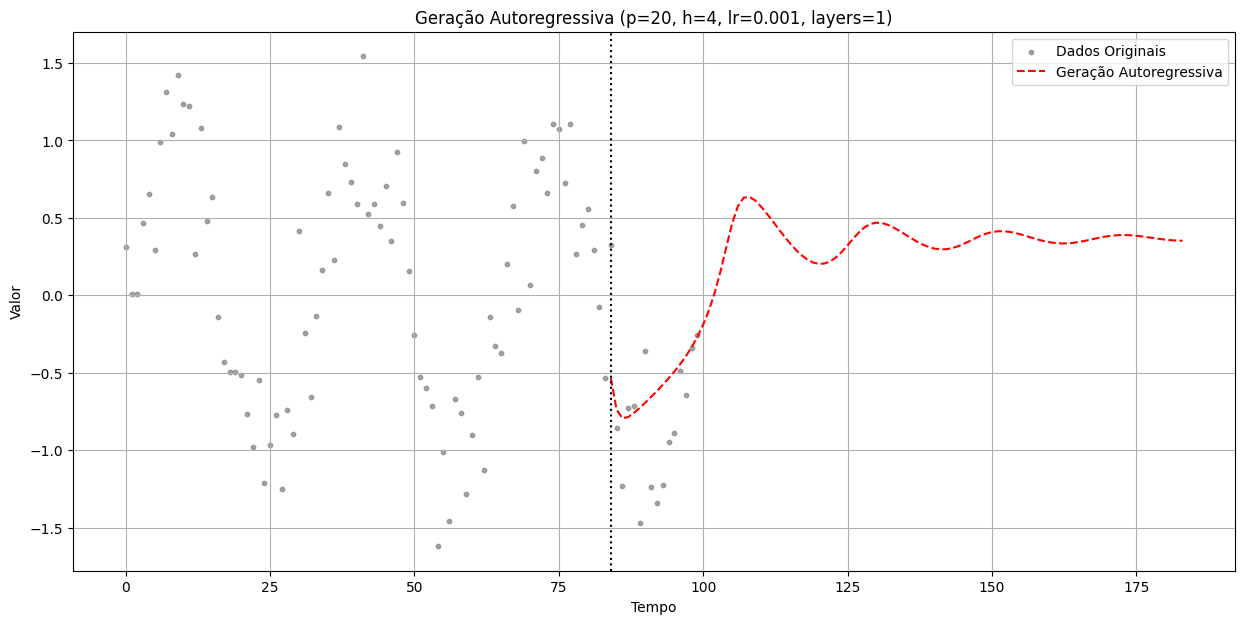


--- TESTE 3: NUM LAYERS (LAYERS=2) ---

--- Treinando Modelo (p=20, h=4, lr=0.01, layers=2) ---
Treinamento concluído! Perda Final (MSE): 0.0346


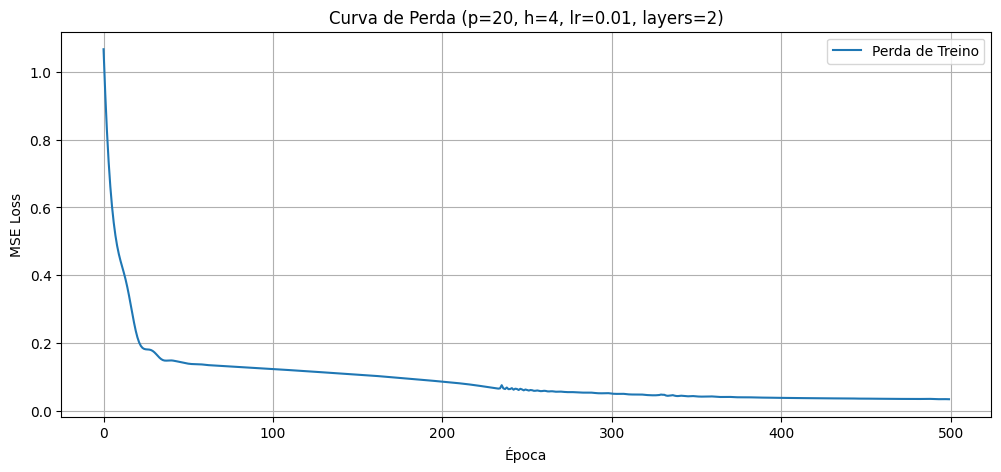

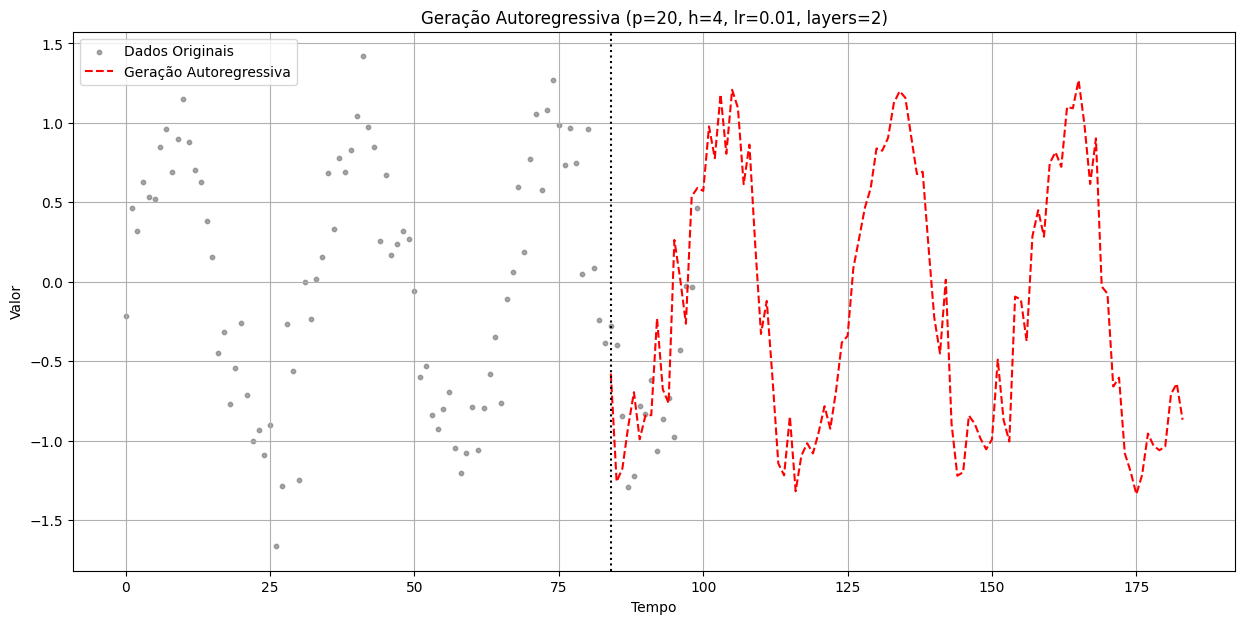

In [24]:
# Reutilização de Funções e Configurações
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

# Classe do Modelo
class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(TimeSeriesPredictor, self).__init__()
        # O parâmetro num_layers permite empilhar RNNs (usado no Ex. 3)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, seq_length, input_size]
        rnn_out, _ = self.rnn(x)
        # Pegamos a saída do último passo de tempo
        # rnn_out: [batch_size, seq_length, hidden_size]
        last_time_step_out = rnn_out[:, -1, :]
        out = self.fc(last_time_step_out)
        return out

def train_and_generate(seq_len, hidden_size, lr, num_layers):
    print(f"\n--- Treinando Modelo (p={seq_len}, h={hidden_size}, lr={lr}, layers={num_layers}) ---")

    # --- 1. Geração e Preparação dos Dados ---
    noise_factor = 0.3
    time_steps = np.linspace(0, 6*np.pi, 100)
    data = np.sin(time_steps) + np.random.randn(len(time_steps)) * noise_factor
    data_tensor = torch.FloatTensor(data).view(-1, 1)

    # Criação das sequências de entrada e saída
    X, y = create_sequences(data_tensor, seq_len)

    # Verifica se há dados suficientes para sequenciamento
    if len(X) == 0:
        print("Erro: seq_length é muito grande para o tamanho do dataset. Ajuste o p.")
        return

    # Divisão em treino (80%) e teste (20%)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    batch_size = 64
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # --- 2. Instanciação e Treinamento ---
    model = TimeSeriesPredictor(input_size=1, hidden_size=hidden_size, output_size=1, num_layers=num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    num_epochs = 500
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for sequences, labels in train_loader:
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

    print(f"Treinamento concluído! Perda Final (MSE): {train_losses[-1]:.4f}")

    # --- 3. Geração Autoregressiva ---
    model.eval()
    if len(X_test) == 0:
        print("Atenção: Dataset de teste muito pequeno para geração. Usando última sequência de treino.")
        current_seq = X_train[-1]
    else:
        current_seq = X_test[0]

    generation_steps = 100
    generated_predictions = []

    with torch.no_grad():
        for _ in range(generation_steps):
            # Adiciona a dimensão do batch
            input_tensor = current_seq.unsqueeze(0)
            prediction = model(input_tensor)
            generated_predictions.append(prediction.item())
            # Atualiza a sequência: remove o primeiro ponto e adiciona a previsão
            current_seq = torch.cat((current_seq[1:], prediction), dim=0)

    # --- 4. Plotagem (Curva de Perda) ---
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Perda de Treino')
    plt.title(f"Curva de Perda (p={seq_len}, h={hidden_size}, lr={lr}, layers={num_layers})")
    plt.xlabel("Época")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 5. Plotagem (Geração) ---
    generated_predictions = np.array(generated_predictions)
    original_data = data_tensor.numpy().flatten()

    seed_end_index = train_size + seq_len

    plt.figure(figsize=(15, 7))
    plt.scatter(range(original_data.shape[0]), original_data, color='gray', alpha=0.7, s=10, label='Dados Originais')
    generated_indices = range(seed_end_index, seed_end_index + generation_steps)
    plt.plot(generated_indices, generated_predictions, label='Geração Autoregressiva', color='red', linestyle='--')
    plt.title(f"Geração Autoregressiva (p={seq_len}, h={hidden_size}, lr={lr}, layers={num_layers})")
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.axvline(x=seed_end_index, color='black', linestyle=':', label='Início da Geração')
    plt.grid(True)
    plt.show()


# EXECUÇÃO DOS TESTES DO EXERCÍCIO 2 E 3
# Parâmetros Base: seq_len=20, hidden_size=4, lr=0.01, num_layers=1

# Exercício 2.1: Tamanho da Camada Oculta (hidden_size)

print("\n--- TESTE 2.1: HIDDEN SIZE (H=10, MAIOR) ---")
train_and_generate(seq_len=20, hidden_size=10, lr=0.01, num_layers=1)

print("\n--- TESTE 2.1: HIDDEN SIZE (H=2, MENOR) ---")
train_and_generate(seq_len=20, hidden_size=2, lr=0.01, num_layers=1)

# Exercício 2.2: Tamanho da Sequência (sequence_length)
print("\n--- TESTE 2.2: SEQUENCE LENGTH (P=5, MENOR) ---")
train_and_generate(seq_len=5, hidden_size=4, lr=0.01, num_layers=1)

print("\n--- TESTE 2.2: SEQUENCE LENGTH (P=50, MAIOR) ---")
train_and_generate(seq_len=50, hidden_size=4, lr=0.01, num_layers=1)

# Exercício 2.3: Taxa de Aprendizado (learning_rate)
print("\n--- TESTE 2.3: LEARNING RATE (LR=0.001, MENOR) ---")
train_and_generate(seq_len=20, hidden_size=4, lr=0.001, num_layers=1)

# Exercício 3: Aprofundando o Modelo (num_layers)
print("\n--- TESTE 3: NUM LAYERS (LAYERS=2) ---")
train_and_generate(seq_len=20, hidden_size=4, lr=0.01, num_layers=2)

Exercício 2
Um modelo maior é sempre melhor?
Não. Um modelo maior (hidden_size alto) converge mais rápido e pode ter melhor precisão, mas aumenta muito o risco de sobreajuste (aprender o ruído). Um modelo deve ser grande o suficiente para capturar o padrão, mas não exagerado.

Qual o impacto de ver mais (ou menos) do passado da série?
Ver mais do passado (sequence_length alto) geralmente melhora a previsão de séries cíclicas, fornecendo o contexto completo do padrão. Ver menos do passado piora, pois o modelo não consegue aprender a dinâmica de longo prazo necessária para replicar a onda.

Exercício 3
O modelo com duas camadas converge mais rápido? A qualidade da geração autorregressiva melhora, piora ou permanece a mesma?
O modelo com duas camadas (num_layers=2) tende a convergir mais devagar inicialmente por ter mais parâmetros. No entanto, a qualidade da geração autorregressiva pode melhorar, pois a profundidade permite que a rede aprenda características mais complexas da sequência.

#### Exercício 4: Controlando a Criatividade com Temperatura

Modifique a célula de geração de texto para incluir um parâmetro de **temperatura** na amostragem, que controla a aleatoriedade da geração. A ideia é dividir os *logits* pela temperatura antes de aplicar a função `softmax`.

-   **Explicação:**
    -   `temperatura < 1.0`: Torna a distribuição de probabilidade mais "afiada", favorecendo os caracteres mais prováveis. O texto fica mais previsível e repetitivo.
    -   `temperatura > 1.0`: Torna a distribuição mais "suave", aumentando a chance de caracteres menos prováveis serem escolhidos. O texto fica mais "criativo", mas também com mais erros.

-   **Tarefa:** Gere textos com pelo menos 3 temperaturas diferentes e compare os resultados.

In [25]:
def generate_text_with_temperature(model, start_seq_list, int_to_char_map, temperature=1.0, generation_steps=100):
    model.eval()

    seed_seq_int = start_seq_list.copy()
    seed_seq_text = ''.join([int_to_char_map[i] for i in seed_seq_int])
    generated_text = seed_seq_text

    with torch.no_grad():
        for _ in range(generation_steps):
            input_tensor = torch.LongTensor([seed_seq_int])

            output_logits = model(input_tensor)

            temp = max(0.001, temperature)
            output_logits_temp = output_logits / temp

            probabilities = nn.functional.softmax(output_logits_temp, dim=1)

            predicted_idx = torch.multinomial(probabilities, 1).item()

            generated_text += int_to_char_map[predicted_idx]
            seed_seq_int = seed_seq_int[1:] + [predicted_idx]

    return generated_text

# --- Execução dos Testes com Diferentes Temperaturas ---

start_idx = 0
seed_seq_int = input_seqs_list[start_idx]

print("\n--- Geração de Texto com Temperatura ---\n")

# 1. Temperatura Baixa (T < 1.0): Texto Frio/Previsível
T_low = 0.2
text_low = generate_text_with_temperature(model_char, seed_seq_int, int_to_char, temperature=T_low)
print(f"Temperatura T={T_low} (Previsível): '{text_low}'")

# 2. Temperatura Média (T = 1.0): Equilíbrio
T_med = 1.0
text_med = generate_text_with_temperature(model_char, seed_seq_int, int_to_char, temperature=T_med)
print(f"Temperatura T={T_med} (Equilíbrio): '{text_med}'")

# 3. Temperatura Alta (T > 1.0): Texto Quente/Criativo
T_high = 2.0
text_high = generate_text_with_temperature(model_char, seed_seq_int, int_to_char, temperature=T_high)
print(f"Temperatura T={T_high} (Criativo/Aleatório): '{text_high}'")


--- Geração de Texto com Temperatura ---

Temperatura T=0.2 (Previsível): 'o rato roeu a roupa do rei de roma roma roma roma roma roma roma roma roma roma roma roma roma roma roma '
Temperatura T=1.0 (Equilíbrio): 'o rato roeu a roupa do rei de roma roma romromr  ro rei de roma roma roma roma roma roma roma roma roma r'
Temperatura T=2.0 (Criativo/Aleatório): 'o rato roeu a roupa do rei de romaeu a roupa doiade roma roma romaarorreu au aa deura ro rei re romau aei'


T=0.2 (Fria): O modelo é muito previsível, caindo em um loop de repetição, pois sempre escolhe o caractere mais provável.

T=1.0 (Padrão): Oferece um equilíbrio com variações e erros menores.

T=2.0 (Quente): O modelo fica caótico e cria erros de vocabulário e estrutura, pois dá chance a caracteres muito improváveis (criatividade excessiva).